<a href="https://colab.research.google.com/github/Raafat-Nagy/Deep-Learning-Projects/blob/main/AutoEncoder/Denoising_Convolution_AutoEncoder_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Convolutional AutoEncoder For MNIST Using TensorFlow


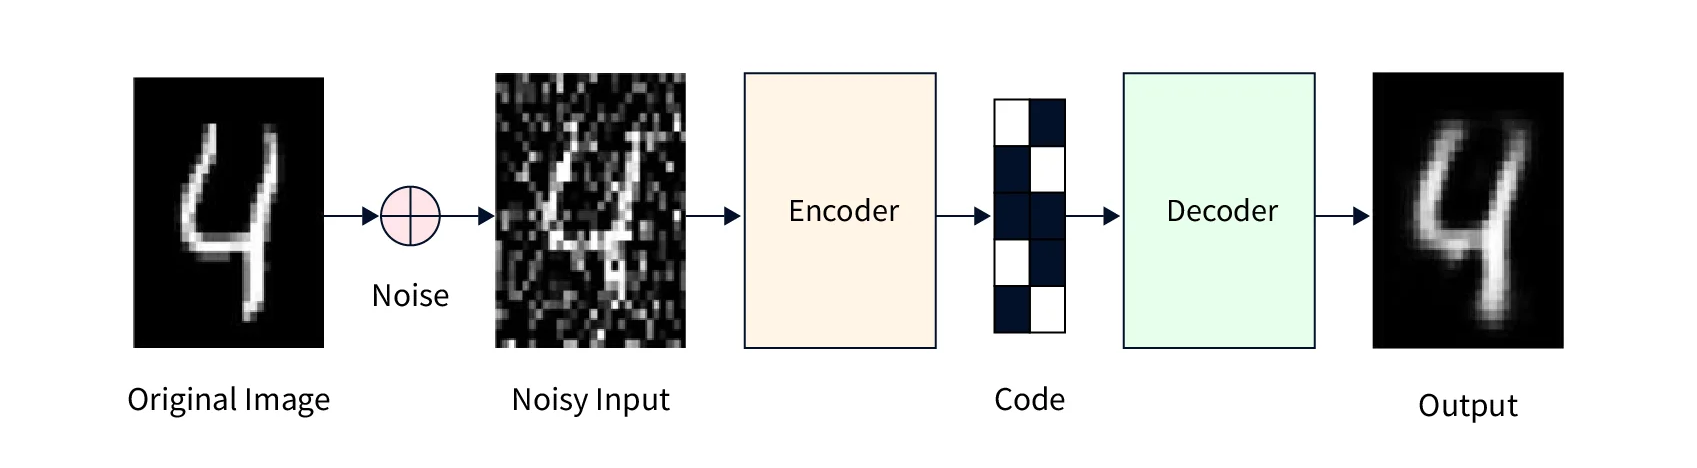

---

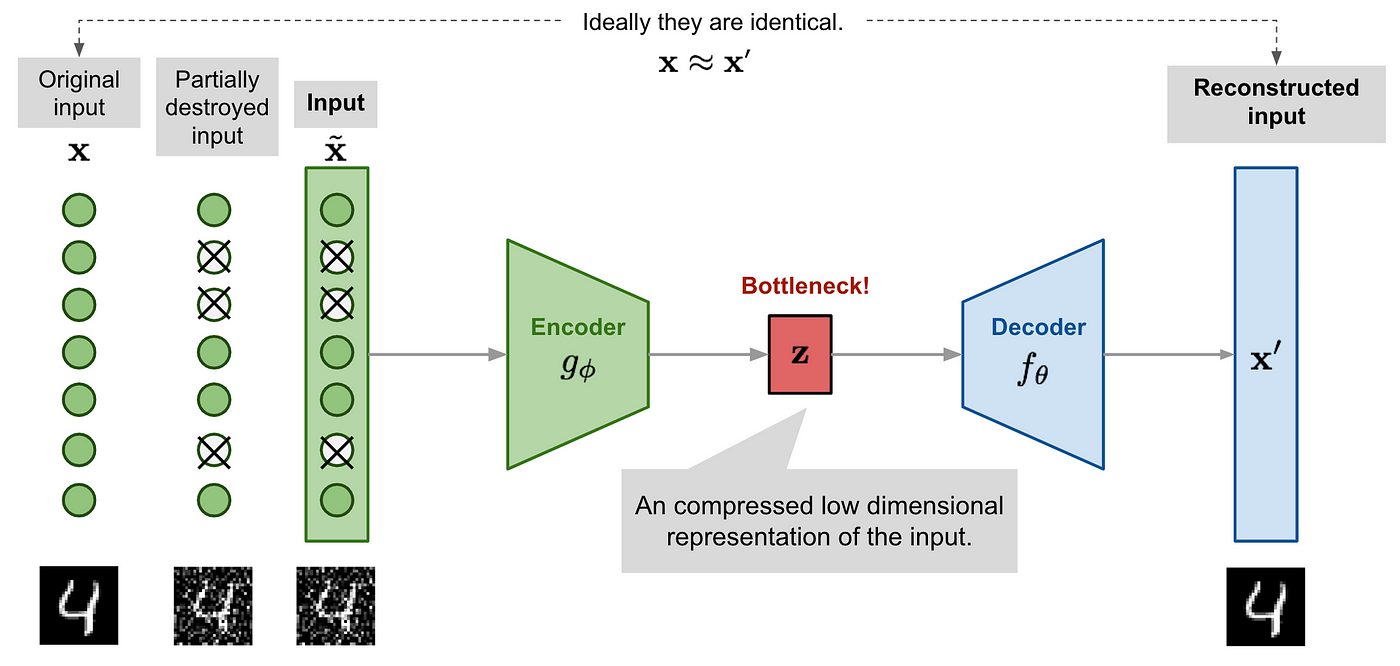

In [2]:
import tensorflow as tf

print(tf.__version__)

2.18.0


## Load & Preprocess Data

In [3]:
from tensorflow.keras.datasets import mnist

# Load MNIST data (ignore the labels)
(x_train, _), (x_test, _) = mnist.load_data()
x_train.shape, x_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [4]:
# Normalize
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [5]:
# Reshape the data to have a single channel (grayscale)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Add Noise

In [6]:
import numpy as np

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

##  Visualize Noisy vs Clean Images

In [8]:
import matplotlib.pyplot as plt

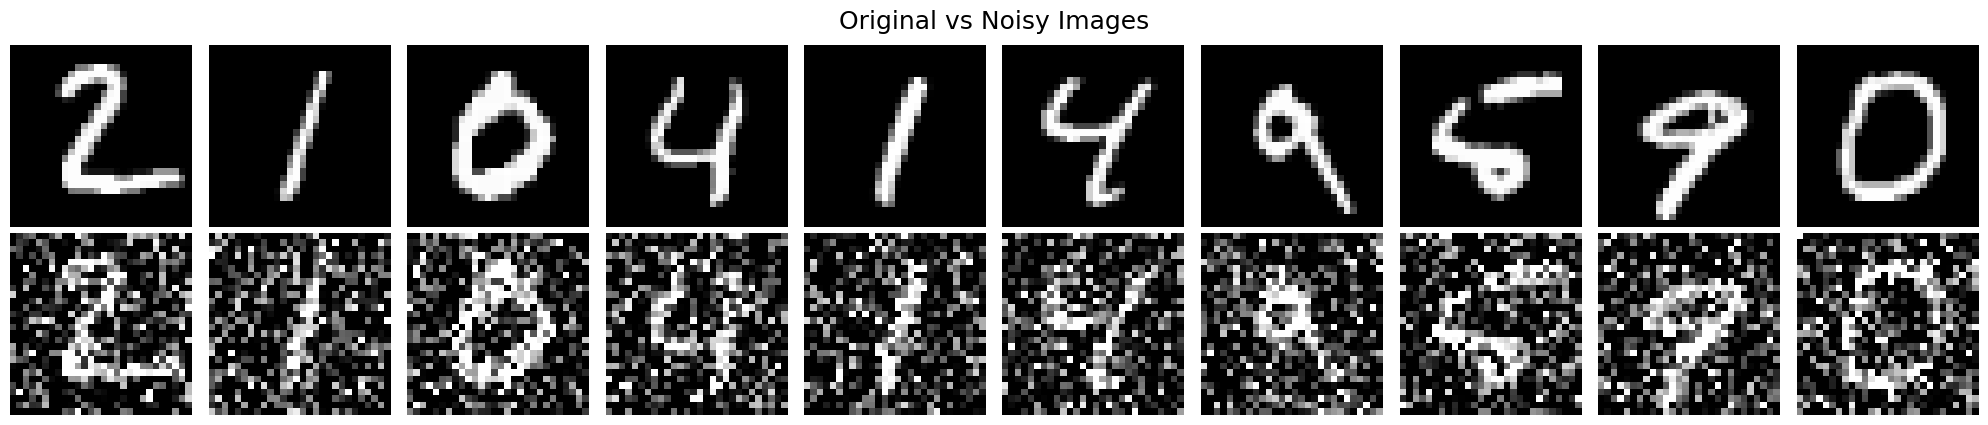

In [27]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Original vs Noisy Images", fontsize=18, y=1.05)
plt.show()

## Build the Denoising AutoEncoder

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(28, 28, 1), name="Input")

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name="Bottleneck")(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="Output")(x)

In [11]:
autoencoder = Model(input_img, decoded, name="DenoisingAutoEncoder")
autoencoder.summary()

Model: "DenoisingAutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (MaxPooling2D)       │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Train the Denoising AutoEncoder

In [13]:
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3458 - val_loss: 0.1353
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1310 - val_loss: 0.1194
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1192 - val_loss: 0.1141
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1145 - val_loss: 0.1105
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1112 - val_loss: 0.1086
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1093 - val_loss: 0.1071
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1082 - val_loss: 0.1058
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1070 - val_loss: 0.1054
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1059 - val_loss: 0.1044
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1054 - val_loss: 0.1037
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1047 - val_loss: 0.1031
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/st

##  Plot Loss Curves

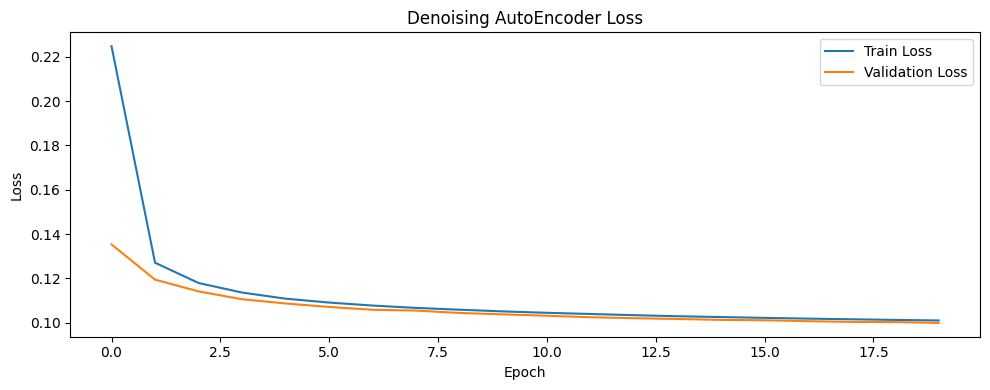

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Denoising AutoEncoder Loss")
plt.tight_layout()
plt.show()

## Reconstruct from Noisy Test Images

In [15]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## Visualize Noisy vs Reconstructed


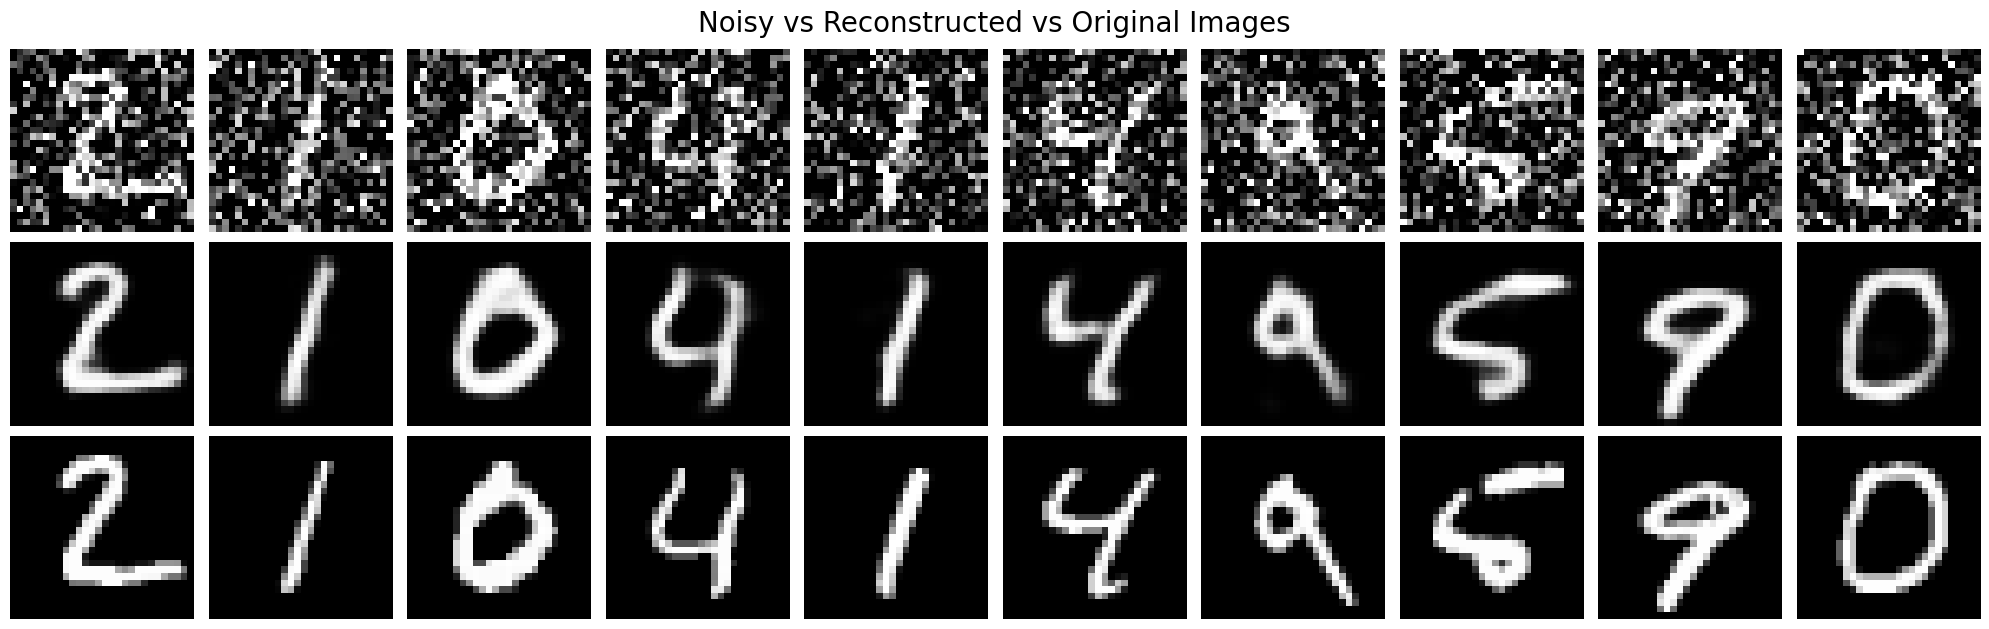

In [24]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(1, n + 1):
    # Noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # Original
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Noisy vs Reconstructed vs Original Images", fontsize=20, y=1.04)
plt.show()

---